# MULTI-FACE MASK DETECTION MODEL

### The goal of this model is to perfectly detect a person correctly or incorreclty wearing a face mask and the one who is not.

In [1]:
# Importing libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import shutil
from zipfile import ZipFile
import os
import cv2
from sklearn.model_selection import train_test_split
from multiprocessing import Process


import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input


In [30]:

def get_all_files(directory): #function to get all files from directory
    paths = []
    for root, dirs, files in os.walk(directory):
              for f_name in files:
                    path = os.path.join(root, f_name) #get a file and add the total path
                    paths.append(path)
    return paths #Return the file paths
directory = 'C:\MINE\DATA SCIENCE\my datasets\MASKS'
paths = get_all_files(directory)

In [3]:
PATH = \
{
    "" : "",
    "CSV" : os.path.join( "DETECT MASK 2", "CSV",  ),
    "IMAGES" : os.path.join( "DETECT MASK 2", "IMAGES",  ),
    "garbage" : os.path.join( "DETECT MASK 2", "IMAGES", "images"  ),
    "train" : os.path.join( "DETECT MASK 2", "IMAGES", "train" ),
    "test" : os.path.join( "DETECT MASK 2", "IMAGES", "test" ),
    "garbage_df" : os.path.join( "DETECT MASK 2", 'training_labels.csv' ),
    "zip_imgs" : os.path.join( "DETECT MASK 2", 'images.zip' )
}

# DATA PREPROCESSING

In [4]:
def unzip():
    print('unzip file')
    with ZipFile('C:\\MINE\\DATA SCIENCE\\my datasets\\MASKS\\images.zip', 'r') as zf:
       #display the files inside the zip
    #    zf.printdir()
       #Extracting the files from zip file
        zf.extractall(path=PATH['IMAGES'],)
    print('zip completed')

In [5]:
def dataset():

    unzip()

    total_imgs = len(os.listdir( PATH['garbage'] ))
    print(f"[INFO] {total_imgs} images in garbage folder 'images' ")

    garbage_df = pd.read_csv( PATH["garbage_df"] )
    print(f"[INFO] {garbage_df.shape[0]} images in df ")


    print(f"[INFO] Creating folders to arrange train images by label ")
    correct_mask_folder = os.path.join(PATH['train'], "1-CORRECT_MASK")
    no_mask_folder = os.path.join(PATH['train'], "0-NO_MASK")
    incorrect_mask_folder = os.path.join(PATH['train'], "2-INCORRECT_MASK")

    os.makedirs(name=correct_mask_folder , exist_ok=True)
    os.makedirs(name=no_mask_folder , exist_ok=True)
    os.makedirs(name=incorrect_mask_folder , exist_ok=True)

    no_mask_filenames = garbage_df[garbage_df.target == 0].image.tolist()
    correct_mask_filenames = garbage_df[garbage_df.target == 1].image.tolist()
    incorrect_mask_filenames = garbage_df[garbage_df.target == 2].image.tolist()

    # Parallel moving
    print(f"[INFO] Moving NO MASK images ")
    _ = []
    for name in no_mask_filenames:
        try:
            p = Process( target=shutil.move, args=(os.path.join( PATH['garbage'],name ), no_mask_folder))
            p.start()
            _ += [p]
        except:
            pass
    
    print(f"[INFO] Moving INCORRECT MASK images ")
    for name in incorrect_mask_filenames:
        try:
            p = Process( target=shutil.move, args=(os.path.join( PATH['garbage'],name ), incorrect_mask_folder))
            p.start()
            _ += [p]
        except:
            pass
    
    
    print(f"[INFO] Moving CORRECT MASK images ")
    for name in correct_mask_filenames:
        try:
            p = Process( target=shutil.move, args=(os.path.join( PATH['garbage'],name ), correct_mask_folder))
            p.start()
            _ += [p]
        except:
            pass
    [p.join() for p in _]

    print(f"[INFO] Rename garbage folder : 'images' --> 'test'")
    os.rename( PATH['garbage'], PATH['test'],  )

    check = total_imgs == (garbage_df.shape[0] + len(os.listdir(PATH['test'])))
    if check:
        print(f"[INFO] Succesful processing")
        print(f"[INFO] {len(os.listdir(correct_mask_folder))} images in folder '{correct_mask_folder}' ")
        print(f"[INFO] {len(os.listdir(no_mask_folder))} images in folder '{no_mask_folder}' ")
        print(f"[INFO] {len(os.listdir(incorrect_mask_folder))} images in folder '{incorrect_mask_folder}' ")
        print(f"[INFO] {len(os.listdir(PATH['test']))} images in folder '{PATH['test']}'.")
    else:
        shutil.rmtree(PATH['IMAGES'])
        os.makedirs(PATH['IMAGES'], exist_ok=True)

        print(f"[INFO] Processing failed, re-run this function please.")


In [6]:
dataset()

unzip file
zip completed
[INFO] 2286 images in garbage folder 'images' 
[INFO] 1955 images in df 
[INFO] Creating folders to arrange train images by label 
[INFO] Moving NO MASK images 
[INFO] Moving INCORRECT MASK images 
[INFO] Moving CORRECT MASK images 
[INFO] Rename garbage folder : 'images' --> 'test'
[INFO] Succesful processing
[INFO] 642 images in folder 'DETECT MASK 2\IMAGES\train\1-CORRECT_MASK' 
[INFO] 658 images in folder 'DETECT MASK 2\IMAGES\train\0-NO_MASK' 
[INFO] 655 images in folder 'DETECT MASK 2\IMAGES\train\2-INCORRECT_MASK' 
[INFO] 331 images in folder 'DETECT MASK 2\IMAGES\test'.


In [7]:

images=[]
size=224,224
def Get_dataset():
    data=[]
    for root,_,file in tqdm(os.walk(PATH['IMAGES'])):
        for name in file:
            file_path=os.path.join(root,name)
            target = os.path.split(root)[-1]
            img = cv2.imread(os.path.join(root,name))
            im = cv2.resize(img,size)
            images.append(im)

            
            data+=[{"file path":file_path,"target":target}]
    return pd.DataFrame(data)

In [9]:
global_data=Get_dataset()

In [10]:
#  CHECKING THE SHAPE
global_data.shape

(2286, 2)

In [11]:

global_data.head(10)

,file path,target
0,DETECT MASK 2\IMAGES\test\10020_Mask_Mouth_Chi...,test
1,DETECT MASK 2\IMAGES\test\10021_Mask_Mouth_Chi...,test
2,DETECT MASK 2\IMAGES\test\10022_Mask_Mouth_Chi...,test
3,DETECT MASK 2\IMAGES\test\13191_Mask_Mouth_Chi...,test
4,DETECT MASK 2\IMAGES\test\13193_Mask_Mouth_Chi...,test
5,DETECT MASK 2\IMAGES\test\13194_Mask_Mouth_Chi...,test
6,DETECT MASK 2\IMAGES\test\13195_Mask_Mouth_Chi...,test
7,DETECT MASK 2\IMAGES\test\13196_Mask_Mouth_Chi...,test
8,DETECT MASK 2\IMAGES\test\13197_Mask_Chin.jpg,test
9,DETECT MASK 2\IMAGES\test\13198_Mask_Mouth_Chi...,test


In [12]:
test_df=pd.DataFrame.where(global_data[['file path']],global_data['target']=='test')
test_df=test_df.dropna()

test_df

,file path
0,DETECT MASK 2\IMAGES\test\10020_Mask_Mouth_Chi...
1,DETECT MASK 2\IMAGES\test\10021_Mask_Mouth_Chi...
2,DETECT MASK 2\IMAGES\test\10022_Mask_Mouth_Chi...
3,DETECT MASK 2\IMAGES\test\13191_Mask_Mouth_Chi...
4,DETECT MASK 2\IMAGES\test\13193_Mask_Mouth_Chi...
...,...
326,DETECT MASK 2\IMAGES\test\ksfdmiebxcibuqxlbtol...
327,DETECT MASK 2\IMAGES\test\ktmunasppplitpubmrdj...
328,DETECT MASK 2\IMAGES\test\kugkqjdlyxywogtbietn...
329,DETECT MASK 2\IMAGES\test\kujdzaccxtihhcwwvsnu...


In [13]:

train_df=global_data.drop(test_df.index)

# to shuffle the data
train_df=train_df.sample(frac=1)
train_df

,file path,target
2186,DETECT MASK 2\IMAGES\train\2-INCORRECT_MASK\38...,2-INCORRECT_MASK
1700,DETECT MASK 2\IMAGES\train\2-INCORRECT_MASK\10...,2-INCORRECT_MASK
1716,DETECT MASK 2\IMAGES\train\2-INCORRECT_MASK\10...,2-INCORRECT_MASK
1219,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0623...,1-CORRECT_MASK
1679,DETECT MASK 2\IMAGES\train\2-INCORRECT_MASK\10...,2-INCORRECT_MASK
...,...,...
1127,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0614...,1-CORRECT_MASK
1132,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0614...,1-CORRECT_MASK
1238,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0625...,1-CORRECT_MASK
1792,DETECT MASK 2\IMAGES\train\2-INCORRECT_MASK\13...,2-INCORRECT_MASK


# IMAGES VISUALIZATION

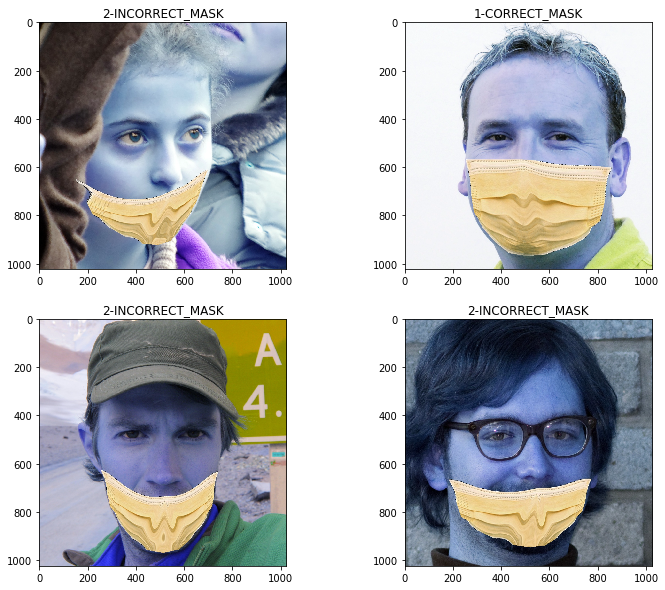

In [14]:
plt.figure(figsize=(12,10))

for i in range (1,5):
    
    img=cv2.imread(np.array(train_df['file path'][1:6])[i])
    ax=plt.subplot(2, 2,i)
    plt.imshow(img)
    plt.title(np.array(train_df['target'][1:6])[i])
    
plt.show()

In [15]:
classes = train_df.target.unique().tolist()
classes

['2-INCORRECT_MASK', '1-CORRECT_MASK', '0-NO_MASK']

In [16]:

train_df=train_df.sample(frac=1)
train_df

,file path,target
1036,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0605...,1-CORRECT_MASK
504,DETECT MASK 2\IMAGES\train\0-NO_MASK\gftflwiwq...,0-NO_MASK
830,DETECT MASK 2\IMAGES\train\0-NO_MASK\uxydkggab...,0-NO_MASK
1277,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0630...,1-CORRECT_MASK
425,DETECT MASK 2\IMAGES\train\0-NO_MASK\djzdqczfw...,0-NO_MASK
...,...,...
509,DETECT MASK 2\IMAGES\train\0-NO_MASK\gkxebviif...,0-NO_MASK
1310,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0633...,1-CORRECT_MASK
1030,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\0604...,1-CORRECT_MASK
1425,DETECT MASK 2\IMAGES\train\1-CORRECT_MASK\3401...,1-CORRECT_MASK


In [17]:
# splitting the train images into train and validation images.

train_data, eval_data = train_test_split(train_df, test_size=0.3, random_state=42)
train_data = train_data.reset_index(drop=True)
eval_data = eval_data.reset_index(drop=True)

# DATA AUGMENTATION

In [18]:
# DATA AUGMENTATION

EPOCHS=30
BS=32


# initialize an our data augmenter as an "empty" image data generator
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.3,
    brightness_range=[0.8,0.9],
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
eval_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(train_data, x_col='file path', y_col='target',target_size=size,
                                                  classes=classes, class_mode='categorical',shuffle=True,batch_size=BS,)

eval_generator=eval_datagen.flow_from_dataframe(eval_data, x_col='file path', y_col='target',target_size=size,
                                                 classes=classes,class_mode='categorical',shuffle=False,batch_size=BS,)

Found 1368 validated image filenames belonging to 3 classes.
Found 587 validated image filenames belonging to 3 classes.


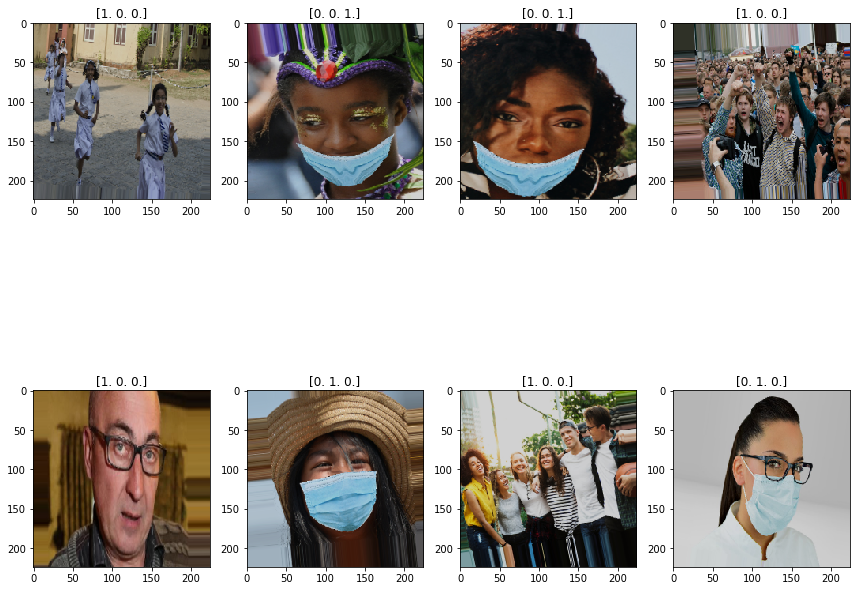

In [19]:
# VISUALIZATION SOME AUGMENTATED INAGES

plt.figure(figsize=(12, 12))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[3]
        plt.imshow(image)
        plt.title(Y_batch[3])
        break
plt.tight_layout()
plt.show()

# BUILDING MODEL

In [20]:
# BUILDING MODEL 
INIT_LR=1e-4

input_tensor = Input(shape=(224, 224, 3))
lastModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_tensor)

FirstModel = lastModel.output
FirstModel = AveragePooling2D(pool_size=(2, 2))(FirstModel)
FirstModel = Dropout(0.4)(FirstModel)
FirstModel = BatchNormalization()(FirstModel)
FirstModel = Flatten(name="flatten")(FirstModel)
FirstModel = Dense(1000, activation="relu")(FirstModel)
FirstModel = Dropout(0.5)(FirstModel)
FirstModel = Dense(3, activation="softmax")(FirstModel)

model = Model(inputs=lastModel.input, outputs=FirstModel)
                   


for layer in lastModel.layers:
    layer.trainable = False

    
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


print("[INFO] training head...")
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=eval_generator.n//eval_generator.batch_size


H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=eval_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,verbose=2)
H


[INFO] compiling model...
[INFO] training head...
Epoch 1/30
42/42 - 92s - loss: 0.4851 - accuracy: 0.8353 - val_loss: 0.1139 - val_accuracy: 0.9601
Epoch 2/30
42/42 - 84s - loss: 0.1444 - accuracy: 0.9424 - val_loss: 0.0681 - val_accuracy: 0.9740
Epoch 3/30
42/42 - 84s - loss: 0.1098 - accuracy: 0.9618 - val_loss: 0.0505 - val_accuracy: 0.9878
Epoch 4/30
42/42 - 88s - loss: 0.1119 - accuracy: 0.9603 - val_loss: 0.0532 - val_accuracy: 0.9809
Epoch 5/30
42/42 - 84s - loss: 0.0799 - accuracy: 0.9716 - val_loss: 0.0493 - val_accuracy: 0.9826
Epoch 6/30
42/42 - 84s - loss: 0.0802 - accuracy: 0.9693 - val_loss: 0.0505 - val_accuracy: 0.9878
Epoch 7/30
42/42 - 84s - loss: 0.0570 - accuracy: 0.9775 - val_loss: 0.0545 - val_accuracy: 0.9878
Epoch 8/30
42/42 - 85s - loss: 0.0969 - accuracy: 0.9731 - val_loss: 0.0544 - val_accuracy: 0.9878
Epoch 9/30
42/42 - 85s - loss: 0.0837 - accuracy: 0.9708 - val_loss: 0.0549 - val_accuracy: 0.9896
Epoch 10/30
42/42 - 84s - loss: 0.0534 - accuracy: 0.9790 -

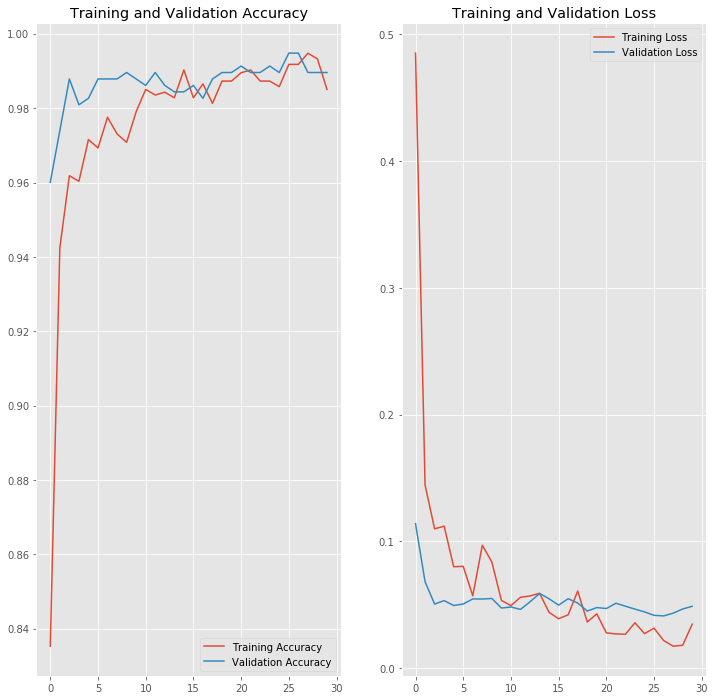

In [21]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss=H.history['loss']
val_loss=H.history['val_loss']

epochs_range = range(EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('mask_detector_New.h5')

[INFO] saving mask detector model...


#  TESTING MODEL

In [23]:
test_df

,file path
0,DETECT MASK 2\IMAGES\test\10020_Mask_Mouth_Chi...
1,DETECT MASK 2\IMAGES\test\10021_Mask_Mouth_Chi...
2,DETECT MASK 2\IMAGES\test\10022_Mask_Mouth_Chi...
3,DETECT MASK 2\IMAGES\test\13191_Mask_Mouth_Chi...
4,DETECT MASK 2\IMAGES\test\13193_Mask_Mouth_Chi...
...,...
326,DETECT MASK 2\IMAGES\test\ksfdmiebxcibuqxlbtol...
327,DETECT MASK 2\IMAGES\test\ktmunasppplitpubmrdj...
328,DETECT MASK 2\IMAGES\test\kugkqjdlyxywogtbietn...
329,DETECT MASK 2\IMAGES\test\kujdzaccxtihhcwwvsnu...


In [24]:
test_df=test_df.sample(frac=1)
test_df

,file path
209,DETECT MASK 2\IMAGES\test\hqeofiflkshpmnrxlccs...
149,DETECT MASK 2\IMAGES\test\bahdwupocidtwpmrhpwd...
277,DETECT MASK 2\IMAGES\test\jhhtcvigjostbkkgggaa...
62,DETECT MASK 2\IMAGES\test\13255_Mask_Mouth_Chi...
230,DETECT MASK 2\IMAGES\test\ifxzqtqiynrhkoaqlpnu...
...,...
312,DETECT MASK 2\IMAGES\test\kigglxwgyxssmujauixj...
281,DETECT MASK 2\IMAGES\test\jiuvimokosuqcqgxsjrp...
255,DETECT MASK 2\IMAGES\test\itsfoylidpuiehheyisj...
198,DETECT MASK 2\IMAGES\test\fvvzssylplidrbhtvshk...


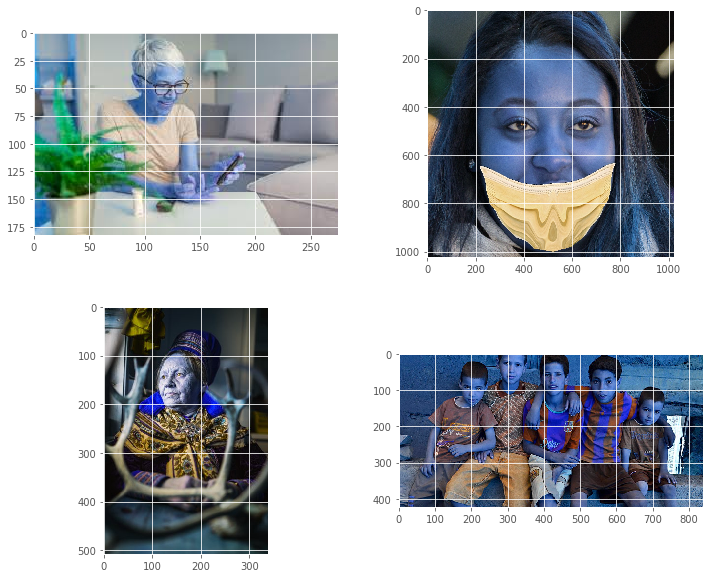

In [25]:
plt.figure(figsize=(12,10))

for i in range (1,5):
    
    img=cv2.imread(np.array(test_df['file path'][1:6])[i])
    ax=plt.subplot(2, 2,i)
    plt.imshow(img)

plt.show()

In [26]:
# Data generation on the test dataset
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='file path',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BS,
    shuffle=False
)

Found 331 validated image filenames.


In [27]:
predictions = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/BS))

predictions

array([[9.57491636e-01, 4.24657352e-02, 4.27342020e-05],
       [2.30240682e-03, 9.17853594e-01, 7.98439384e-02],
       [1.00000000e+00, 5.46071608e-12, 5.85803988e-14],
       [7.41836887e-12, 3.28660583e-08, 1.00000000e+00],
       [1.00000000e+00, 3.95496690e-17, 2.59398392e-09],
       [9.99998331e-01, 1.22262861e-06, 4.50309557e-07],
       [9.99988675e-01, 2.42590126e-09, 1.13565457e-05],
       [5.86202020e-07, 1.93623295e-09, 9.99999404e-01],
       [9.99992847e-01, 7.10525592e-06, 3.16596669e-08],
       [1.74347065e-11, 1.00000000e+00, 1.81256760e-10],
       [9.99993801e-01, 5.72589887e-09, 6.20941864e-06],
       [2.30067720e-09, 3.03094687e-08, 1.00000000e+00],
       [6.71850228e-15, 5.84809712e-09, 1.00000000e+00],
       [5.28149968e-10, 1.00000000e+00, 5.10051912e-09],
       [9.41442341e-11, 1.00000000e+00, 5.54566038e-09],
       [1.00000000e+00, 7.55288809e-09, 8.36642144e-10],
       [1.24736874e-10, 4.01690486e-04, 9.99598324e-01],
       [9.99982476e-01, 3.32947

The rrsult a tuple of 3 values, the first is the probability that the image contain face with no mask, second for correct mask and last one for incorrect mask.